In [4]:
!pip install numpy pandas matplotlib seaborn scikit-learn nltk wordcloud transformers torch tqdm

In [1]:
# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Word cloud
from wordcloud import WordCloud

# Transformer and deep learning
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Utility
from tqdm import tqdm


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"

df = pd.read_csv(
    url,
    sep='\t',
    header=None,
    names=['label', 'message']
)


In [4]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [6]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


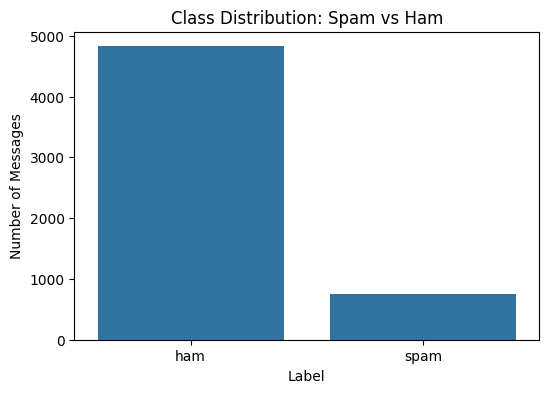

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution: Spam vs Ham")
plt.xlabel("Label")
plt.ylabel("Number of Messages")
plt.show()


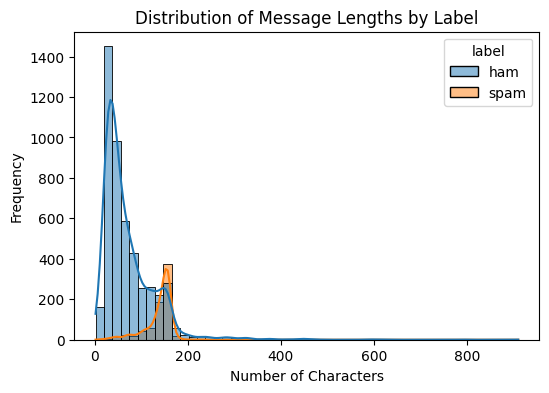

In [8]:
df['text_length'] = df['message'].apply(len)

plt.figure(figsize=(6,4))
sns.histplot(df, x='text_length', hue='label', bins=50, kde=True)
plt.title("Distribution of Message Lengths by Label")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()


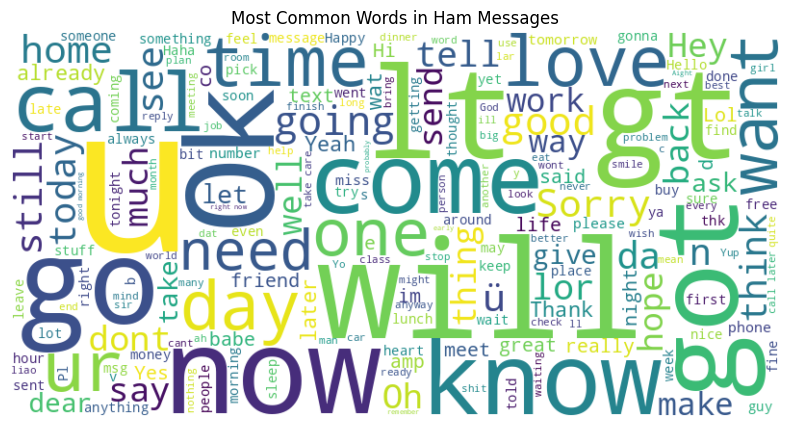

In [9]:
ham_text = " ".join(df[df['label']=='ham']['message'])

wordcloud_ham = WordCloud(width=800, height=400, background_color='white').generate(ham_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Ham Messages")
plt.show()


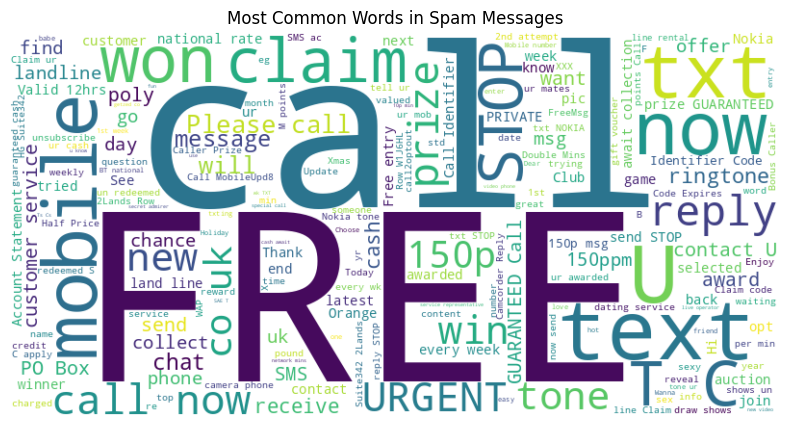

In [10]:
spam_text = " ".join(df[df['label']=='spam']['message'])

wordcloud_spam = WordCloud(width=800, height=400, background_color='white').generate(spam_text)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Spam Messages")
plt.show()


In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [13]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)


In [14]:
preprocess_text("WINNER!! You have won 1000 dollars!!!")

'winner dollar'

In [15]:
df['cleaned_message'] = df['message'].apply(preprocess_text)

In [16]:
df.head()

,label,message,text_length,cleaned_message
0,ham,"Go until jurong point, crazy.. Available only ...",111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,nah dont think go usf life around though


Step 8: Train-Test Split

We first separate the dataset into features (X) and labels (y), and then split it into training and testing sets.

In [17]:
# Features and labels
X = df['cleaned_message']
y = df['label'].map({'ham': 0, 'spam': 1})  # Encode labels numerically

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Explanation for the report:

train_test_split separates data into training and testing subsets.

stratify=y ensures that the class distribution remains the same in both sets, which is important due to class imbalance.

This allows us to train the model on the training data and evaluate its performance on unseen testing data.

We convert text into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency).

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # Limit features for efficiency

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


TF-IDF transforms each message into a vector of numerical weights representing the importance of words.

Words that appear frequently in a message but rarely across the dataset get higher scores.

Limiting max_features=5000 reduces computational cost while retaining meaningful patterns.

The training vectorizer is fitted on the training data and then applied to the test set to avoid information leakage.

In [21]:
print("Shape of training data:", X_train_tfidf.shape)
print("Shape of test data:", X_test_tfidf.shape)


Shape of training data: (4457, 5000)
Shape of test data: (1115, 5000)


In [22]:
# Initialize the model
nb_model = MultinomialNB()

# Train the model on the TF-IDF features
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [23]:
y_pred = nb_model.predict(X_test_tfidf)


In [24]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Detailed classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.9641255605381166
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       1.00      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115



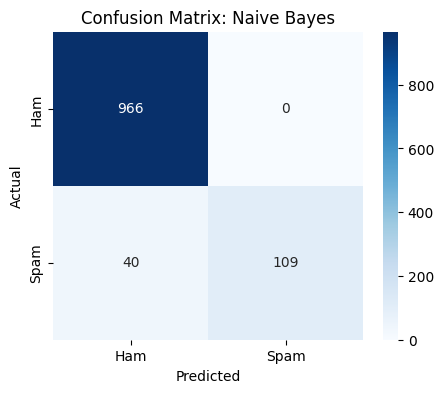

In [25]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Naive Bayes")
plt.show()

# BERT

In [26]:
!pip install -q transformers

In [27]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Use AdamW from torch.optim
from torch.optim import AdamW


In [28]:
le = LabelEncoder()
y_encoded = le.fit_transform(df['label'])  # ham=0, spam=1

In [29]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize all messages
tokens = tokenizer(
    df['message'].tolist(),
    max_length=64,       # max sequence length
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
# Features
input_ids = tokens['input_ids']
attention_masks = tokens['attention_mask']
labels = torch.tensor(y_encoded)

# Train-test split
train_size = int(0.8 * len(labels))
test_size = len(labels) - train_size

train_dataset, test_dataset = random_split(
    TensorDataset(input_ids, attention_masks, labels),
    [train_size, test_size]
)


In [31]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [32]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2  # spam or ham
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
optimizer = AdamW(model.parameters(), lr=2e-5)

total_steps = len(train_loader) * 3  # 3 epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [34]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

        model.zero_grad()
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels
        )

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 - Loss: 0.0866
Epoch 2 - Loss: 0.0196
Epoch 3 - Loss: 0.0065


In [35]:
model.eval()
preds = []
true_labels = []

for batch in test_loader:
    b_input_ids, b_attention_mask, b_labels = [x.to(device) for x in batch]

    with torch.no_grad():
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask
        )
    logits = outputs.logits
    preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
    true_labels.extend(b_labels.cpu().numpy())

# Metrics
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds))


Accuracy: 0.9955156950672646
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       964
           1       0.99      0.98      0.98       151

    accuracy                           1.00      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       1.00      1.00      1.00      1115



In [48]:
custom_messages = [
    "Hey are we still meeting for lunch tomorrow?",
    "Can you send me the assignment pdf when free?",
    "Congratulations! You have won a free iPhone. Click the link now",
    "URGENT: Your account has been suspended. Verify immediately",
    "I will call you in the evening",
    "Free entry in a weekly contest. Text WIN to 80085",
    "Don’t forget the meeting at 10 am",
    "You have been selected for a cash prize of $5000",
    "Are you coming to class today?",
    "Please review the document I sent last night",
    "Claim your free gift card worth $100 now",
    "Your loan has been approved. Contact us immediately",
    "Let’s catch up over coffee this weekend",
    "Reminder: submit your project by midnight",
    "Win big rewards by participating in our survey",
    "Exclusive deal just for you. Limited time offer",
    "I will be late today due to traffic",
    "Your OTP code is 482931. Do not share it",
    "Lowest price guaranteed. Buy now and save more",
    "Meeting postponed to tomorrow morning"
]

custom_labels = [
    "ham",
    "ham",
    "spam",
    "spam",
    "ham",
    "spam",
    "ham",
    "spam",
    "ham",
    "ham",
    "spam",
    "spam",
    "ham",
    "ham",
    "spam",
    "spam",
    "ham",
    "ham",
    "spam",
    "ham"
]


In [49]:
X_custom_tfidf = tfidf.transform(custom_messages)

In [50]:
nb_predictions = nb_model.predict(X_custom_tfidf)

In [51]:
for msg, pred in zip(custom_messages, nb_predictions):
    print(f"Message: {msg}")
    print(f"Predicted by Naive Bayes: {pred}")
    print()


Message: Hey are we still meeting for lunch tomorrow?
Predicted by Naive Bayes: 0

Message: Can you send me the assignment pdf when free?
Predicted by Naive Bayes: 0

Message: Congratulations! You have won a free iPhone. Click the link now
Predicted by Naive Bayes: 0

Message: URGENT: Your account has been suspended. Verify immediately
Predicted by Naive Bayes: 1

Message: I will call you in the evening
Predicted by Naive Bayes: 0

Message: Free entry in a weekly contest. Text WIN to 80085
Predicted by Naive Bayes: 1

Message: Don’t forget the meeting at 10 am
Predicted by Naive Bayes: 0

Message: You have been selected for a cash prize of $5000
Predicted by Naive Bayes: 1

Message: Are you coming to class today?
Predicted by Naive Bayes: 0

Message: Please review the document I sent last night
Predicted by Naive Bayes: 0

Message: Claim your free gift card worth $100 now
Predicted by Naive Bayes: 1

Message: Your loan has been approved. Contact us immediately
Predicted by Naive Bayes:

In [52]:
encoded = tokenizer(
    custom_messages,
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

encoded = {k: v.to(model.device) for k, v in encoded.items()}

In [53]:
model.eval()

with torch.no_grad():
    outputs = model(**encoded)
    logits = outputs.logits
    bert_predictions = torch.argmax(logits, dim=1)


In [54]:
label_map = {0: "ham", 1: "spam"}

for msg, pred in zip(custom_messages, bert_predictions):
    print(f"Message: {msg}")
    print(f"Predicted by BERT: {label_map[pred.item()]}")
    print()

Message: Hey are we still meeting for lunch tomorrow?
Predicted by BERT: ham

Message: Can you send me the assignment pdf when free?
Predicted by BERT: ham

Message: Congratulations! You have won a free iPhone. Click the link now
Predicted by BERT: spam

Message: URGENT: Your account has been suspended. Verify immediately
Predicted by BERT: ham

Message: I will call you in the evening
Predicted by BERT: ham

Message: Free entry in a weekly contest. Text WIN to 80085
Predicted by BERT: spam

Message: Don’t forget the meeting at 10 am
Predicted by BERT: ham

Message: You have been selected for a cash prize of $5000
Predicted by BERT: spam

Message: Are you coming to class today?
Predicted by BERT: ham

Message: Please review the document I sent last night
Predicted by BERT: ham

Message: Claim your free gift card worth $100 now
Predicted by BERT: spam

Message: Your loan has been approved. Contact us immediately
Predicted by BERT: ham

Message: Let’s catch up over coffee this weekend
Pre

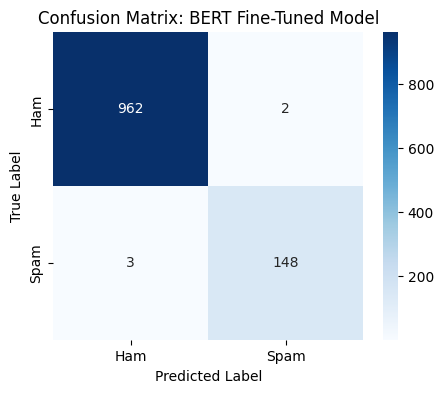

In [55]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm_bert = confusion_matrix(true_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Ham', 'Spam'],
    yticklabels=['Ham', 'Spam']
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: BERT Fine-Tuned Model")
plt.show()

In [56]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [57]:
# Get spam probabilities for Naive Bayes
nb_probs = nb_model.predict_proba(X_test_tfidf)[:, 1]

# ROC values
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_probs)
auc_nb = auc(fpr_nb, tpr_nb)


In [58]:
import torch.nn.functional as F

bert_probs = []

model.eval()
for batch in test_loader:
    b_input_ids, b_attention_mask, _ = [x.to(device) for x in batch]
    with torch.no_grad():
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask
        )
        probs = F.softmax(outputs.logits, dim=1)
        bert_probs.extend(probs[:, 1].cpu().numpy())

# ROC values
fpr_bert, tpr_bert, _ = roc_curve(true_labels, bert_probs)
auc_bert = auc(fpr_bert, tpr_bert)


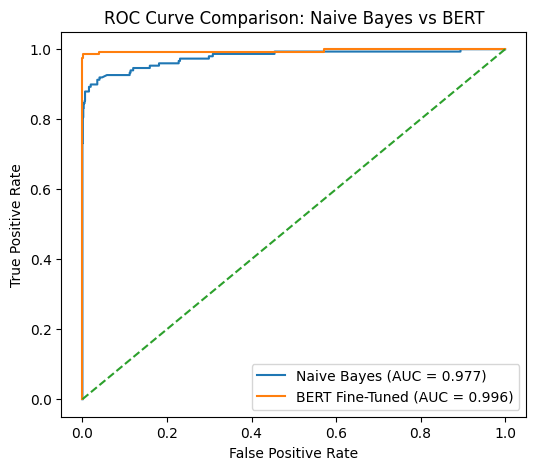

In [59]:
plt.figure(figsize=(6,5))

plt.plot(fpr_nb, tpr_nb, label=f"Naive Bayes (AUC = {auc_nb:.3f})")
plt.plot(fpr_bert, tpr_bert, label=f"BERT Fine-Tuned (AUC = {auc_bert:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison: Naive Bayes vs BERT")
plt.legend(loc="lower right")
plt.show()
